In [2]:
# All the imports

from __future__ import print_function, division
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import MaxPooling2D, merge
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import losses
from keras.utils import to_categorical
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import glob

import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, Callback, TensorBoard
from keras import backend as keras

from scipy.io import loadmat
from scipy.ndimage import zoom
#from scipy.misc import imresize
import pywt

import random
import time
%matplotlib inline  

#import hdf5storage

import scipy.io as sio
from skimage.filters import threshold_otsu


from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)

Using TensorFlow backend.


In [2]:
wavelet_type = 'db3'

In [149]:
# Do reconstruction after doing the wavelet replacement

ypred = model.predict(xtest)
ypred = np.reshape(ypred[0, :, :, :, 0], [60, 36, 28])
ypred = ypred*100.0
print(ypred.shape)

ccpred    = ytest[0]
temp      = ypred[3:-3, 1:-1, 1:-1]
temp      = np.moveaxis(temp, [2, 0, 1], [0, 1, 2])
print(temp.shape)
ccpred[0] = temp

print(ccpred[0].shape)

newvol    = pywt.waverecn(ccpred, wavelet_type)
print(newvol.shape)

(60, 36, 28)
(26, 54, 34)
(26, 54, 34)
(350, 804, 480)


In [ ]:
# Doing it in loop for all the dataset

path1 = '/media/pranjal/2d33dff3-95f7-4dc0-9842-a9b18bcf1bf9/pranjal/duke_phantom/25_proj_wave_full_resolution_6_iterations/'
path2 = '/media/pranjal/2d33dff3-95f7-4dc0-9842-a9b18bcf1bf9/pranjal/duke_phantom/25_proj_pred_full_resolution/'

wavelet_type = 'db3'

for i in range(1, 177):
    print(i)
    
    xtest        = []
    ytest        = []
    
    path = path1+str(i)+'.mat'
    a    = hdf5storage.loadmat(path)
    a    = a['recSART_all']
    
    vol          = np.reshape(a[5, :, :, :], [350, 804, 480])
    cc25         = pywt.wavedecn(vol, wavelet_type, mode='symmetric', level=4)
    ytest.append(cc25)

    vol         = np.moveaxis(cc25[0], [0, 1, 2], [2, 0, 1])

    xtest.append(vol)
    xtest = np.array(xtest)

    xtest = (xtest-20)/20.0
    #xtest = xtest/100.0
    xtest = np.expand_dims(xtest, axis=4)
    xtest = np.pad(xtest, ((0,0), (3, 3), (1, 1), (1, 1), (0, 0)), 'constant', constant_values = (0, 0))
    
    ypred = model.predict(xtest)
    ypred = np.reshape(ypred[0, :, :, :, 0], [60, 36, 28])
    #ypred = ypred*100.0
    ypred = ypred*30+30

    ccpred    = ytest[0]
    temp      = ypred[3:-3, 1:-1, 1:-1]
    temp      = np.moveaxis(temp, [2, 0, 1], [0, 1, 2])
    ccpred[0] = temp
    
    newvol    = pywt.waverecn(ccpred, wavelet_type)
    
    savepath  = path2+str(i)+'.npy'
    np.save(savepath, newvol)

In [ ]:
# For testing the result images

index  = 120
t1 = np.reshape(newvol[index, :, :], [804, 480])
t2 = np.reshape(vol65[index, :, :], [804, 480])
t3 = np.reshape(vol25[index, :, :], [804, 480])
t4 = np.reshape(vol_replace[index, :, :], [804, 480])

#image = np.concatenate((t1, t2, t3), axis=1)
image = np.concatenate((t3, t1, t4, t2), axis=1)

plt.figure(figsize=(15, 80))
plt.imshow(image, cmap='gray')

#db3 result

In [ ]:
# For testing the result iamge
index  = 540
t1 = np.reshape(newvol[:, index, :], [350, 480])
t2 = np.reshape(vol65[:, index, :], [350, 480])
t3 = np.reshape(vol25[:, index, :], [350, 480])
t4 = np.reshape(vol_replace[:, index, :], [350, 480])

#image = np.concatenate((t1, t2, t3), axis=1)
image = np.concatenate((t3, t1, t4, t2), axis=1)

plt.figure(figsize=(15, 80))
plt.imshow(image, cmap='gray')

#db3 result

In [16]:
savepath = '/media/dril/72fd13fc-2566-4738-946e-a92bad2acf3d/dril/duke_phantom/SART/db3/new_norm_test1/'

In [2]:
# 3d U-net model

def unet_3d_prelu_cond(input_size = (60, 36, 28, 1)):
    filter0 = 16
    filter1 = 32
    filter2 = 64
    filter3 = 128
    
    inputs   = Input(input_size)
    
    #class_variable  = Input(shape=(1,)) 
    #class_v1 = Embedding(3, 128)(class_v)
    #class_v1 = Flatten()(class_v1)
    #class_variable = Dense(1, input_shape=(128, ), activation='relu')(class_v1)
    
    conv0 = Conv3D(filter0, 3, padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv0 = BatchNormalization()(conv0)
    conv0 = ReLU()(conv0)
    #conv0 = Dropout(0.1)(conv0)
    
    #conv0_ones = Lambda(lambda x: K.ones_like(x, dtype='float32'))(conv0)
    #conv0_cond = Lambda(lambda x: tf.multiply(class_variable[:, None, None ,None], x))(conv0_ones)
    #conv0_cond = concatenate([conv0, conv0_cond])
    
    conv0 = Conv3D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv0)
    conv0 = BatchNormalization()(conv0)
    conv0 = ReLU()(conv0)
    #conv0 = Dropout(0.1)(conv0)
    
    #conv0_ones = Lambda(lambda x: tf.ones_like(x, dtype='float32'))(conv0)
    #conv0_cond = Lambda(lambda x: tf.multiply(class_variable[:, None, None ,None], x))(conv0_ones)
    #conv0_cond = concatenate([conv0, conv0_cond])
        
    conv1 = Conv3D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv0)
    conv1 = BatchNormalization()(conv1)
    conv1 = ReLU()(conv1)
    #conv1 = Dropout(0.1)(conv1)
    
    pool1 = MaxPooling3D(pool_size=(2,2,2))(conv1)
    
    #pool1_ones = Lambda(lambda x: tf.ones_like(x, dtype='float32'))(pool1)
    #pool1_cond = Lambda(lambda x: tf.multiply(class_variable[:, None, None ,None], x))(pool1_ones)
    #pool1_cond = concatenate([pool1, pool1_cond])
    
    conv2 = Conv3D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = ReLU()(conv2)
    #conv2 = Dropout(0.1)(conv2)
    
    pool2 = MaxPooling3D(pool_size=(2, 2,2))(conv2)
    
    #pool2_ones = Lambda(lambda x: tf.ones_like(x, dtype='float32'))(pool2)
    #pool2_cond = Lambda(lambda x: tf.multiply(class_variable[:, None, None ,None], x))(pool2_ones)
    
    conv3 = Conv3D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = ReLU()(conv3)
    #conv3 = Dropout(0.1)(conv3)
        
    up6 = Conv3D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(conv3))
    up6 = BatchNormalization()(up6)
    up6 = ReLU()(up6)
    #up6 = Dropout(0.1)(up6)
    
    #up6_ones = Lambda(lambda x: tf.ones_like(x, dtype='float32'))(up6)
    #up6_cond = Lambda(lambda x: tf.multiply(class_variable[:, None, None ,None], x))(up6_ones)
    
    merge6   = Add()([up6,conv2]) #concatenate([, up6_cond])
    
    conv6 = Conv3D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = ReLU()(conv6)
    #conv6 = Dropout(0.1)(conv6)
    
    up7 = Conv3D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(conv6))
    up7 = BatchNormalization()(up7)
    up7 = ReLU()(up7)
    #up7 = Dropout(0.1)(up7)
    
    #up7_ones = Lambda(lambda x: tf.ones_like(x, dtype='float32'))(up7)
    #up7_cond = Lambda(lambda x: tf.multiply(class_variable[:, None, None ,None], x))(up7_ones)
    
    merge7   = Add()([up7, conv1])#concatenate([, up7_cond])
    
    conv6 = Conv3D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv6 = BatchNormalization()(conv6)
    conv6 = ReLU()(conv6)
    #conv6 = Dropout(0.1)(conv6)

    #conv6_ones = Lambda(lambda x: tf.ones_like(x, dtype='float32'))(conv6)
    #conv6_cond = Lambda(lambda x: tf.multiply(class_variable[:, None, None ,None], x))(conv6_ones)
    
    conv6 = Conv3D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = ReLU()(conv6)
    #conv6 = Dropout(0.1)(conv6)
    
    #conv6_ones = Lambda(lambda x: tf.ones_like(x, dtype='float32'))(conv6)
    #conv6_cond = Lambda(lambda x: tf.multiply(class_variable[:, None, None ,None], x))(conv6_ones)
                                                                                    
    conv6 = Conv3D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = PReLU()(conv6)
    #conv6 = Dropout(0.1)(conv6)
    
    #conv6_ones = Lambda(lambda x: tf.ones_like(x, dtype='float32'))(conv6)
    #conv6_cond = Lambda(lambda x: tf.multiply(class_variable[:, None, None ,None], x))(conv6_ones)
                                                                                   
    conv6 = Conv3D(filter0, 3, padding = 'same', kernel_initializer = 'he_normal')(conv6)
    #conv6 = BatchNormalization()(conv6)
    conv6 = PReLU()(conv6)
    #conv6 = Dropout(0.1)(conv6)
    
    conv9 = Conv3D(1, 1, padding='same', kernel_initializer = 'he_normal')(conv6)
    conv9 = PReLU()(conv9)
    
    model = Model(input = inputs, output = conv9)

    model.compile(optimizer = Adam(lr = 0.0001), loss = 'mean_absolute_error', metrics = ['mae'])
    
    #model.summary()

    #if(pretrained_weights):
    #    model.load_weights(pretrained_weights)

    return model

def unet_3d_prelu(input_size = (60, 36, 28, 1)):
    filter0 = 32
    filter1 = 64
    filter2 = 64
    filter3 = 128
    
    inputs = Input(input_size)
    
    conv0 = Conv3D(filter0, 3, padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv0 = ReLU()(conv0)
    conv0 = BatchNormalization()(conv0)
    conv0 = Dropout(0.1)(conv0)
    
    conv0 = Conv3D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv0)
    conv0 = ReLU()(conv0)
    conv0 = BatchNormalization()(conv0)
    conv0 = Dropout(0.1)(conv0)
    
    conv1 = Conv3D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv0)
    conv1 = ReLU()(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Dropout(0.1)(conv1)
    
    #conv1 = Conv3D(32, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    #conv1 = BatchNormalization()(conv1)
    #conv1 = ReLU()(conv1)
    #conv1 = Dropout(0.25)(conv1)
    
    pool1 = MaxPooling3D(pool_size=(2,2,2))(conv1)
    
    conv2 = Conv3D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = ReLU()(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Dropout(0.1)(conv2)
    
    
#     conv2 = Conv3D(64, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv2)
#     conv2 = BatchNormalization()(conv2)
#     conv2 = ReLU()(conv2)
#     conv2 = Dropout(0.25)(conv2)
    
    pool2 = MaxPooling3D(pool_size=(2, 2,2))(conv2)
    
    conv3 = Conv3D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = ReLU()(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Dropout(0.1)(conv3)
    
#     conv3 = Conv3D(256, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv3)
#     conv3 = BatchNormalization()(conv3)
#     conv3 = ReLU()(conv3)
#     conv3 = Dropout(0.25)(conv3)
    
    up6 = Conv3D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(conv3))
    up6 = ReLU()(up6)
    up6 = BatchNormalization()(up6)
    up6 = Dropout(0.1)(up6)
    
    merge6 = concatenate([up6, conv2])
    
    conv6 = Conv3D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = ReLU()(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Dropout(0.1)(conv6)
    
    up7 = Conv3D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(conv6))
    up7 = ReLU()(up7)
    up7 = BatchNormalization()(up7)
    up7 = Dropout(0.1)(up7)
    
    merge7 = concatenate([up7, conv1])
    
    conv6 = Conv3D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv6 = ReLU()(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Dropout(0.1)(conv6)

    conv6 = Conv3D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6 = ReLU()(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Dropout(0.1)(conv6)
    
    conv6 = Conv3D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6 = ReLU()(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Dropout(0.1)(conv6)
    
    conv6 = Conv3D(filter0, 3, padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6 = ReLU()(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Dropout(0.1)(conv6)
    
    conv9 = Conv3D(1, 1, padding='same', kernel_initializer = 'he_normal')(conv6)
    conv9 = ReLU()(conv9)
    
    model = Model(input = inputs, output = conv9)

    model.compile(optimizer = Adam(lr = 0.0001), loss = 'mse', metrics = ['mae'])
    
    model.summary()

    #if(pretrained_weights):
    #    model.load_weights(pretrained_weights)

    return model

In [19]:
# Read the Training Data

startnum = 0;

xpath         = '/home/dril/dbt_recon/WAVEDEC4_VOLUMES/50_proj_wave_4/'
y_100_path    = '/home/dril/dbt_recon/WAVEDEC4_VOLUMES/100_proj_wave_4/'
y_130_path    = '/home/dril/dbt_recon/WAVEDEC4_VOLUMES/130_proj_wave_4/'
y_180_path    = '/home/dril/dbt_recon/WAVEDEC4_VOLUMES/180_proj_wave_4/'

samples          = 176
validate_samples = 6

In [5]:
#t    = np.array(range(samples))
#perm = np.random.permutation(len(t))
#np.save('perm.npy', perm)

In [6]:
perm = np.load('perm.npy')

In [20]:
# For reading the training data and doing some preproscessing

xtrain       = []
x_cond_train = []

y_100_train = []
y_130_train = []
y_180_train = []

tmax1_a = []
tmax2_a = []

# Reading the data in loop
for k in range(samples):
    i = perm[k]+1
    
    x = loadmat(xpath+str(startnum+i)+'.mat')
    x = x['recSART_all']
    for j in range(10, 12): # only considering after the first 10 iterations
        xt = x[j, :, :, :]
        xt = np.moveaxis(xt, [0, 1, 2], [2, 0, 1])
        tmax1 = np.max(xt)
        xt   = (xt-10)/20.0
        tmax1_a.append(tmax1)
        xtrain.append(xt)
    
    x = loadmat(y_180_path+str(startnum+i)+'.mat')
    x = x['img']
    x = np.moveaxis(x, [0, 1, 2], [2, 0, 1])
    x = (x-15)/30.0
    for j in range(2):
        y_180_train.append(x)
    
    x = loadmat(y_130_path+str(startnum+i)+'.mat')
    x = x['recSART_all']
    x = np.moveaxis(x, [0, 1, 2], [2, 0, 1])
    x = (x-15)/30.0
    for j in range(2):
        y_130_train.append(x)
    
    x = loadmat(y_100_path+str(startnum+i)+'.mat')
    x = x['recSART_all']
    x = np.moveaxis(x, [0, 1, 2], [2, 0, 1])
    x = (x-15)/30.0
    for j in range(2):
        y_100_train.append(x)
    

xtrain      = np.array(xtrain)
y_100_train = np.array(y_100_train)
y_130_train = np.array(y_130_train)
y_180_train = np.array(y_180_train)

xtrain      = np.expand_dims(xtrain, axis=4)
y_100_train = np.expand_dims(y_100_train, axis=4)
y_130_train = np.expand_dims(y_130_train, axis=4)
y_180_train = np.expand_dims(y_180_train, axis=4)

xtrain       = np.pad(xtrain,      ((0,0), (3, 3), (1, 1), (1, 1), (0, 0)), 'constant', constant_values = (0, 0))
y_100_train  = np.pad(y_100_train, ((0,0), (3, 3), (1, 1), (1, 1), (0, 0)), 'constant', constant_values = (0, 0))
y_130_train  = np.pad(y_130_train, ((0,0), (3, 3), (1, 1), (1, 1), (0, 0)), 'constant', constant_values = (0, 0))
y_180_train  = np.pad(y_180_train, ((0,0), (3, 3), (1, 1), (1, 1), (0, 0)), 'constant', constant_values = (0, 0))

#print(xtrain.shape)
#xtrain_v      = xtrain[-70:, :, :, :, :]
#y_100_train_v = y_100_train[-70:, :, :, :, :] 
#y_130_train_v = y_130_train[-70:, :, :, :, :]
#y_180_train_v = y_180_train[-70:, :, :, :, :]

#xtrain      = xtrain[:-70, :, :, :, :]
#y_100_train = y_100_train[:-70, :, :, :, :]
#y_130_train = y_130_train[:-70, :, :, :, :]
#y_180_train = y_180_train[:-70, :, :, :, :]

print(xtrain.shape)
print(y_100_train.shape)
print(y_130_train.shape)
print(y_180_train.shape)

#print(xtrain_v.shape)
#print(y_100_train_v.shape)
#print(y_130_train_v.shape)
#print(y_180_train_v.shape)

(352, 60, 36, 28, 1)
(352, 60, 36, 28, 1)
(352, 60, 36, 28, 1)
(352, 60, 36, 28, 1)


In [24]:
# For generating the conditioning variables

x_cond_train = np.concatenate((np.ones(len(xtrain))*0.25, np.ones(len(xtrain))*0.5, np.ones(len(xtrain))*1), axis=0)
xtrain       = np.concatenate((xtrain, xtrain, xtrain), axis=0)
ytrain       = np.concatenate((y_100_train, y_130_train, y_180_train), axis=0)

x_cond_train_v = np.concatenate((np.ones(len(xtrain_v))*0.25, np.ones(len(xtrain_v))*0.5, np.ones(len(xtrain_v))*1), axis=0)
xtrain_v       = np.concatenate((xtrain_v, xtrain_v, xtrain_v), axis=0)
ytrain_v       = np.concatenate((y_100_train_v, y_130_train_v, y_180_train_v), axis=0)


print(x_cond_train.shape)
print(xtrain.shape)
print(ytrain.shape)

print(x_cond_train_v.shape)
print(xtrain_v.shape)
print(ytrain_v.shape)

(846,)
(846, 60, 36, 28, 1)
(846, 60, 36, 28, 1)
(210,)
(210, 60, 36, 28, 1)
(210, 60, 36, 28, 1)


In [24]:
# For storing the results

image_indexes_result      = []
temp_image_indexes_result = []
slice_indexes_result      = []

def store_results(epoch, x, y, model, saveseed=5):
    global image_indexes_result
    global slice_indexes_result
    global temp_image_indexes_result
    
    imgshape = 200
    
    r, c = 6, 6
    
    #random.seed(saveseed)
    
    #plt.subplots_adjust(top=0.92, bottom=0.38, left=0.40, right=0.75)
    #plt.tight_layout()
    fig, axs = plt.subplots(r, c, figsize=(90,30))
    cnt      = 0
    
    cleanimg = model.predict(x, batch_size=4)
    
    for i in range(r):
        for j in range(c):
            if len(image_indexes_result) == 0:
                imgindex   = random.randint(1, 68)
                sliceindex = random.randint(30, 40)
                
                temp_image_indexes_result.append(imgindex)
                slice_indexes_result.append(sliceindex)
            else:
                imgindex   = image_indexes_result[cnt]
                sliceindex = slice_indexes_result[cnt]
            
            combined = np.array([x[imgindex, sliceindex, :, :, 0], cleanimg[imgindex, sliceindex, :, :, 0], y[imgindex, sliceindex, :, :, 0]])
            combined = np.hstack(combined.reshape(3, 36, 28))
            
            axs[i,j].imshow(combined, cmap='gray')
            axs[i, j].set_xticklabels([])
            axs[i, j].set_yticklabels([])
            axs[i,j].axis('off')
            cnt += 1
    
    if len(image_indexes_result) == 0:
        image_indexes_result = temp_image_indexes_result
    
    #print(temp_image_indexes_result)
    plt.subplots_adjust(wspace=0.1, hspace=0)
    
    print('saving image ', savepath)
    fig.savefig(savepath+"clean_%d.png" % epoch, bbox_inches='tight')
    plt.close()

In [22]:
# Callback for storing results

class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        if epoch%10 == 0:
            store_results(epoch, x, y, self.model)

In [23]:
model = unet_3d_prelu_cond()

/home/dril/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("p_...)`


In [8]:
# For checkpoint

checkpoint  = ModelCheckpoint(monitor='val_loss', verbose=1, filepath='/home/dril/SummerWork/new_norm_test1.h5', period=10)
reduce_lr   = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.000001)
t = time.time()
print('Tensorflow time ', t)
tensorboard = TensorBoard(log_dir="logs/{}".format(t))
#tensorboard = TensorBoard(log_dir="logs/1551025594.89692")

Tensorflow time  1561178567.360167


In [26]:
#model.save_weights('cond_model_small_prelu_l1_1561092785.h5')

In [25]:
#import numpy as np

#from np.random import permutation

#perm = np.random.permutation(len(xtrain))
#np.save('perm.npy', perm)


#xtrain = xtrain[perm]
#ytrain = ytrain[perm]
ytrain = y_180_train

#model.load_weights('/media/pranjal/de24af8d-2361-4ea2-a07a-1801b54488d9/duke_phantom/SART/db3/models_small3/duke_model_small3.h5')
model.fit(xtrain, y_180_train, batch_size=5, epochs=10000, validation_split=0.2,  callbacks=[checkpoint, tensorboard, TestCallback((xtrain[-70:-1, :, :, :, :], ytrain[-70:-1, :, :, :, :]))])

Train on 281 samples, validate on 71 samples
Epoch 1/10000
281/281 [==============================] - 14s 50ms/step - loss: 0.3970 - mean_absolute_error: 0.3970 - val_loss: 0.3465 - val_mean_absolute_error: 0.3465
saving image  /media/dril/72fd13fc-2566-4738-946e-a92bad2acf3d/dril/duke_phantom/SART/db3/new_norm_test1/
Epoch 2/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.3168 - mean_absolute_error: 0.3168 - val_loss: 0.3096 - val_mean_absolute_error: 0.3096
Epoch 3/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.3104 - mean_absolute_error: 0.3104 - val_loss: 0.3029 - val_mean_absolute_error: 0.3029
Epoch 4/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.3038 - mean_absolute_error: 0.3038 - val_loss: 0.3002 - val_mean_absolute_error: 0.3002
Epoch 5/10000
281/281 [==============================] - 13s 46ms/step - loss: 0.2954 - mean_absolute_error: 0.2954 - val_loss: 0.2965 - val_mean_absolute_error: 0.2965
Epoc

281/281 [==============================] - 13s 45ms/step - loss: 0.0189 - mean_absolute_error: 0.0189 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241

Epoch 00088: saving model to /home/dril/SummerWork/cascade1.h5
Epoch 89/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0185 - mean_absolute_error: 0.0185 - val_loss: 0.0234 - val_mean_absolute_error: 0.0234
Epoch 90/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0187 - mean_absolute_error: 0.0187 - val_loss: 0.0237 - val_mean_absolute_error: 0.0237
Epoch 91/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0184 - mean_absolute_error: 0.0184 - val_loss: 0.0230 - val_mean_absolute_error: 0.0230
saving image  /media/dril/72fd13fc-2566-4738-946e-a92bad2acf3d/dril/duke_phantom/SART/db3/new_norm_test1/
Epoch 92/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0184 - mean_absolute_error: 0.0184 - val_loss: 0.0238 - val_mean_absolute_error: 0.

saving image  /media/dril/72fd13fc-2566-4738-946e-a92bad2acf3d/dril/duke_phantom/SART/db3/new_norm_test1/
Epoch 132/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0167 - mean_absolute_error: 0.0167 - val_loss: 0.0223 - val_mean_absolute_error: 0.0223
Epoch 133/10000
281/281 [==============================] - 13s 46ms/step - loss: 0.0168 - mean_absolute_error: 0.0168 - val_loss: 0.0232 - val_mean_absolute_error: 0.0232
Epoch 134/10000
281/281 [==============================] - 13s 46ms/step - loss: 0.0163 - mean_absolute_error: 0.0163 - val_loss: 0.0218 - val_mean_absolute_error: 0.0218
Epoch 135/10000
281/281 [==============================] - 13s 46ms/step - loss: 0.0161 - mean_absolute_error: 0.0161 - val_loss: 0.0222 - val_mean_absolute_error: 0.0222
Epoch 136/10000
281/281 [==============================] - 13s 46ms/step - loss: 0.0164 - mean_absolute_error: 0.0164 - val_loss: 0.0235 - val_mean_absolute_error: 0.0235
Epoch 137/10000
281/281 [==============

281/281 [==============================] - 13s 45ms/step - loss: 0.0136 - mean_absolute_error: 0.0136 - val_loss: 0.0219 - val_mean_absolute_error: 0.0219
Epoch 220/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0135 - mean_absolute_error: 0.0135 - val_loss: 0.0220 - val_mean_absolute_error: 0.0220
Epoch 221/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0134 - mean_absolute_error: 0.0134 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
saving image  /media/dril/72fd13fc-2566-4738-946e-a92bad2acf3d/dril/duke_phantom/SART/db3/new_norm_test1/
Epoch 222/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0135 - mean_absolute_error: 0.0135 - val_loss: 0.0209 - val_mean_absolute_error: 0.0209
Epoch 223/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0134 - mean_absolute_error: 0.0134 - val_loss: 0.0217 - val_mean_absolute_error: 0.0217
Epoch 224/10000
281/281 [==============================

281/281 [==============================] - 13s 45ms/step - loss: 0.0122 - mean_absolute_error: 0.0122 - val_loss: 0.0217 - val_mean_absolute_error: 0.0217
Epoch 307/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0120 - mean_absolute_error: 0.0120 - val_loss: 0.0218 - val_mean_absolute_error: 0.0218
Epoch 308/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0123 - mean_absolute_error: 0.0123 - val_loss: 0.0214 - val_mean_absolute_error: 0.0214

Epoch 00308: saving model to /home/dril/SummerWork/cascade1.h5
Epoch 309/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0121 - mean_absolute_error: 0.0121 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 310/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0122 - mean_absolute_error: 0.0122 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 311/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0126 - mean_ab

281/281 [==============================] - 13s 45ms/step - loss: 0.0110 - mean_absolute_error: 0.0110 - val_loss: 0.0209 - val_mean_absolute_error: 0.0209
Epoch 393/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0111 - mean_absolute_error: 0.0111 - val_loss: 0.0209 - val_mean_absolute_error: 0.0209
Epoch 394/10000
281/281 [==============================] - 13s 46ms/step - loss: 0.0111 - mean_absolute_error: 0.0111 - val_loss: 0.0223 - val_mean_absolute_error: 0.0223
Epoch 395/10000
281/281 [==============================] - 13s 46ms/step - loss: 0.0110 - mean_absolute_error: 0.0110 - val_loss: 0.0209 - val_mean_absolute_error: 0.0209
Epoch 396/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0112 - mean_absolute_error: 0.0112 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 397/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0109 - mean_absolute_error: 0.0109 - val_loss: 0.0210 - val_mean_absolute_erro

281/281 [==============================] - 13s 45ms/step - loss: 0.0107 - mean_absolute_error: 0.0107 - val_loss: 0.0213 - val_mean_absolute_error: 0.0213
Epoch 437/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0104 - mean_absolute_error: 0.0104 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208
Epoch 438/10000
281/281 [==============================] - 13s 46ms/step - loss: 0.0106 - mean_absolute_error: 0.0106 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211

Epoch 00438: saving model to /home/dril/SummerWork/cascade1.h5
Epoch 439/10000
281/281 [==============================] - 13s 46ms/step - loss: 0.0106 - mean_absolute_error: 0.0106 - val_loss: 0.0218 - val_mean_absolute_error: 0.0218
Epoch 440/10000
281/281 [==============================] - 13s 46ms/step - loss: 0.0106 - mean_absolute_error: 0.0106 - val_loss: 0.0209 - val_mean_absolute_error: 0.0209
Epoch 441/10000
281/281 [==============================] - 13s 46ms/step - loss: 0.0103 - mean_ab

281/281 [==============================] - 13s 45ms/step - loss: 0.0100 - mean_absolute_error: 0.0100 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 523/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0098 - mean_absolute_error: 0.0098 - val_loss: 0.0214 - val_mean_absolute_error: 0.0214
Epoch 524/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0102 - mean_absolute_error: 0.0102 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 525/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0098 - mean_absolute_error: 0.0098 - val_loss: 0.0213 - val_mean_absolute_error: 0.0213
Epoch 526/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0097 - mean_absolute_error: 0.0097 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 527/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0101 - mean_absolute_error: 0.0101 - val_loss: 0.0220 - val_mean_absolute_erro

281/281 [==============================] - 13s 45ms/step - loss: 0.0095 - mean_absolute_error: 0.0095 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 567/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0096 - mean_absolute_error: 0.0096 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 568/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0099 - mean_absolute_error: 0.0099 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212

Epoch 00568: saving model to /home/dril/SummerWork/cascade1.h5
Epoch 569/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0099 - mean_absolute_error: 0.0099 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 570/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0094 - mean_absolute_error: 0.0094 - val_loss: 0.0215 - val_mean_absolute_error: 0.0215
Epoch 571/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0096 - mean_ab

281/281 [==============================] - 13s 45ms/step - loss: 0.0091 - mean_absolute_error: 0.0091 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 653/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0091 - mean_absolute_error: 0.0091 - val_loss: 0.0214 - val_mean_absolute_error: 0.0214
Epoch 654/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0092 - mean_absolute_error: 0.0092 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 655/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0091 - mean_absolute_error: 0.0091 - val_loss: 0.0206 - val_mean_absolute_error: 0.0206
Epoch 656/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0090 - mean_absolute_error: 0.0090 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 657/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0094 - mean_absolute_error: 0.0094 - val_loss: 0.0209 - val_mean_absolute_erro

281/281 [==============================] - 13s 45ms/step - loss: 0.0092 - mean_absolute_error: 0.0092 - val_loss: 0.0209 - val_mean_absolute_error: 0.0209
Epoch 697/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0093 - mean_absolute_error: 0.0093 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 698/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0091 - mean_absolute_error: 0.0091 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210

Epoch 00698: saving model to /home/dril/SummerWork/cascade1.h5
Epoch 699/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0089 - mean_absolute_error: 0.0089 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 700/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0087 - mean_absolute_error: 0.0087 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 701/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0089 - mean_ab

281/281 [==============================] - 13s 45ms/step - loss: 0.0087 - mean_absolute_error: 0.0087 - val_loss: 0.0214 - val_mean_absolute_error: 0.0214
Epoch 783/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0084 - mean_absolute_error: 0.0084 - val_loss: 0.0215 - val_mean_absolute_error: 0.0215
Epoch 784/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0086 - mean_absolute_error: 0.0086 - val_loss: 0.0209 - val_mean_absolute_error: 0.0209
Epoch 785/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0087 - mean_absolute_error: 0.0087 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207
Epoch 786/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0083 - mean_absolute_error: 0.0083 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208
Epoch 787/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0083 - mean_absolute_error: 0.0083 - val_loss: 0.0207 - val_mean_absolute_erro

281/281 [==============================] - 13s 45ms/step - loss: 0.0084 - mean_absolute_error: 0.0084 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 827/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0082 - mean_absolute_error: 0.0082 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 828/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0082 - mean_absolute_error: 0.0082 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208

Epoch 00828: saving model to /home/dril/SummerWork/cascade1.h5
Epoch 829/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0085 - mean_absolute_error: 0.0085 - val_loss: 0.0213 - val_mean_absolute_error: 0.0213
Epoch 830/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0081 - mean_absolute_error: 0.0081 - val_loss: 0.0209 - val_mean_absolute_error: 0.0209
Epoch 831/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0082 - mean_ab

281/281 [==============================] - 13s 45ms/step - loss: 0.0077 - mean_absolute_error: 0.0077 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208
Epoch 913/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0080 - mean_absolute_error: 0.0080 - val_loss: 0.0213 - val_mean_absolute_error: 0.0213
Epoch 914/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0077 - mean_absolute_error: 0.0077 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208
Epoch 915/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0078 - mean_absolute_error: 0.0078 - val_loss: 0.0217 - val_mean_absolute_error: 0.0217
Epoch 916/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0081 - mean_absolute_error: 0.0081 - val_loss: 0.0215 - val_mean_absolute_error: 0.0215
Epoch 917/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0084 - mean_absolute_error: 0.0084 - val_loss: 0.0217 - val_mean_absolute_erro

281/281 [==============================] - 13s 45ms/step - loss: 0.0079 - mean_absolute_error: 0.0079 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207
Epoch 957/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0080 - mean_absolute_error: 0.0080 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 958/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0079 - mean_absolute_error: 0.0079 - val_loss: 0.0220 - val_mean_absolute_error: 0.0220

Epoch 00958: saving model to /home/dril/SummerWork/cascade1.h5
Epoch 959/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0082 - mean_absolute_error: 0.0082 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 960/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0077 - mean_absolute_error: 0.0077 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 961/10000
281/281 [==============================] - 13s 45ms/step - loss: 0.0077 - mean_ab

KeyboardInterrupt: 

In [27]:
model.save_weights('/media/dril/72fd13fc-2566-4738-946e-a92bad2acf3d/dril/duke_phantom/SART/db3/models_small3/1560897401.8170357_only_relu_less_conditoning_l1.h5')

In [78]:
# For second stage training

perm       = np.load('perm.npy')
batch_size = 12

train_input_data_path = '/media/pranjal/de24af8d-2361-4ea2-a07a-1801b54488d9/duke_phantom/SART/db3/stage_two_data/train/input/'
train_pred_data_path  = '/media/pranjal/de24af8d-2361-4ea2-a07a-1801b54488d9/duke_phantom/SART/db3/stage_two_data/train/pred/'

valid_input_data_path = '/media/pranjal/de24af8d-2361-4ea2-a07a-1801b54488d9/duke_phantom/SART/db3/stage_two_data/train/input/'
valid_pred_data_path  = '/media/pranjal/de24af8d-2361-4ea2-a07a-1801b54488d9/duke_phantom/SART/db3/stage_two_data/train/pred/'

test_data_path  = '/media/pranjal/de24af8d-2361-4ea2-a07a-1801b54488d9/duke_phantom/SART/db3/stage_two_data/train/output/'


def train_generator():
    while True:
        index_list  = random.sample(range(1, 140), batch_size)
        sample_list = random.sample(range(1, 69),  batch_size)
        
        alldata_x = []
        alldata_y = []
        
        for k in range(len(index_list)):
            # Read from the training set used for training the 3D CNN
            i = perm[index_list[k]]+1
            
            in_data   = np.load(train_input_data_path+str(i)+'_'+str(sample_list[k])+'.npy')
            pred_data = np.load(train_pred_data_path+str(i)+'_'+str(sample_list[k])+'.npy')
            out_data  = np.load(test_data_path+str(i)+'_'+str(sample_list[k])+'.npy')
            
            a = np.concatenate((in_data, pred_data), axis=-1)
            b = out_data
            
            alldata_x.append(a)
            alldata_y.append(b)
        
        alldata_x = np.array(alldata_x)
        alldata_y = np.array(alldata_y)
        #print(alldata_x.shape, alldata_y.shape)
        yield alldata_x, alldata_y

def validation_generator():
    while True:
        index_list  = random.sample(range(141, 175), batch_size)
        sample_list = random.sample(range(1, 69),  batch_size)
        
        alldata_x = []
        alldata_y = []
        
        for k in range(len(index_list)):
            # Read from the training set used for training the 3D CNN
            i = perm[index_list[k]]+1
            
            in_data   = np.load(valid_input_data_path+str(i)+'_'+str(sample_list[k])+'.npy')
            pred_data = np.load(valid_pred_data_path+str(i)+'_'+str(sample_list[k])+'.npy')
            out_data  = np.load(test_data_path+str(i)+'_'+str(sample_list[k])+'.npy')
            
            a = np.concatenate((in_data, pred_data), axis=-1)
            b = out_data
            
            alldata_x.append(a)
            alldata_y.append(b)
        
        alldata_x = np.array(alldata_x)
        alldata_y = np.array(alldata_y)
        #print(alldata_x.shape, alldata_y.shape)
        yield alldata_x, alldata_y

In [ ]:
model = unet_2d_prelu()

In [95]:
# Second stage training of model
checkpoint  = ModelCheckpoint(filepath='/media/pranjal/de24af8d-2361-4ea2-a07a-1801b54488d9/duke_phantom/SART/db3/models_small3/duke_model_small3_0001_second_stage.h5', monitor='val_loss', period=5, verbose=1, save_best_only=True, mode='min')
t           = time.time()
print('Tensorflow time ', t)
tensorboard = TensorBoard(log_dir="logs/{}".format(t))

Tensorflow time  1551328985.776317


In [ ]:
# Second stage training loop

model.fit_generator(train_generator(),
                    use_multiprocessing=True,
                    steps_per_epoch=100,
                    epochs=10000,
                    validation_data=validation_generator(),
                    validation_steps=20,
                    callbacks=[checkpoint, tensorboard])

In [ ]:
import os.path
import time

counter         = 0
phantom_counter = 0

for phantom_counter in range(220, 250):
    print(phantom_counter)
    for counter in range(5, 26):
        if counter%5 == 0:
            fname     = '/media/pranjal/2d33dff3-95f7-4dc0-9842-a9b18bcf1bf9/pranjal/DBT_data/network-infer-volume-partial-5/'+str(phantom_counter)+'_'+str(counter)+'.mat'
            net_fname = '/media/pranjal/2d33dff3-95f7-4dc0-9842-a9b18bcf1bf9/pranjal/DBT_data/network-infer-volume-partial-5/'+str(phantom_counter)+'_net_'+str(counter)+'.mat'

            while(True):
                if os.path.isfile(fname):
                    try:
                        temp = []
                        a = sio.loadmat(fname)
                        a = np.moveaxis(a['res_temp'], [0, 1, 2], [2, 0, 1])
                        temp.append(a)
                        temp = np.array(temp)
                        temp = np.expand_dims(temp, axis=4)
                        temp = model.predict(temp)
                        temp = temp[0, :, :, :, 0]
                        img = np.moveaxis(temp,  [2, 0, 1], [0, 1, 2])
                        sio.savemat(net_fname, {'img':img})
                        print('File created ', time.time())
                        break
                    except:
                        print('File not ready yet trying again')
                        time.sleep(5)
                else:
                    #print('Going to sleep')
                    time.sleep(5)
    

(32, 120, 48)
(120, 48, 32)
(120, 48, 32)
(32, 120, 48)


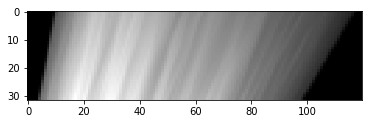

In [21]:
a = sio.loadmat('/media/pranjal/de24af8d-2361-4ea2-a07a-1801b54488d9/DBT_recon_data/network-infer-volume/1_1.mat')
temp = a['res_temp']
print(temp.shape)
temp = np.moveaxis(temp, [0, 1, 2], [2, 0, 1])
print(temp.shape)
tp1 = []
tp1.append(temp)
tp1 = np.array(tp1)
tp1 = np.expand_dims(tp1, axis=4)
temp = tp1[0, :, :, :, 0]
print(temp.shape)
temp = np.moveaxis(temp,  [2, 0, 1], [0, 1, 2])
print(temp.shape)
plt.imshow(temp[:, :, 24]*2, cmap='gray')

In [ ]:
import socket

HOST = 'localhost' 
PORT = 50007
s    = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
s.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
s.bind((HOST, PORT))



while True:
    s.listen(4)
    print("waiting for response from client at port ",PORT)
    (conn, (ip, port)) = s.accept()
    
    print('Connected by', ip)
    print('hello')
    
    newthread         = ClientThread(ip, port, conn)
    newthread.start()
conn.close()

#     data = conn.recv(1024)
    
#     print(data)
    
#     clientdata = "hello client".encode()
#     conn.sendall(clientdata)
    

In [2]:
import socket 
from threading import Thread 

# Multithreaded Python server : TCP Server Socket Thread Pool
class ClientThread(Thread): 
 
    def __init__(self, ip, port, conn): 
        Thread.__init__(self) 
        self.ip   = ip 
        self.port = port 
        self.conn = conn
        print("[+] New server socket thread started for " + ip + ":" + str(port))
 
    def run(self):
        data = self.conn.recv(2048) 
        print("Server received data:", data)
        self.conn.send("Message recieved".encode())
        self.conn.close()

In [31]:
def unet_3d_ReLU_pancreas(input_size = (40, 80, 40, 1)):
    filter0 = 64
    filter1 = 128
    filter2 = 256
    filter3 = 512
    
    inputs          = Input(input_size)
    #pca_mean_tensor = Input((81920,))
    
    conv0 = Conv3D(filter0, 3, padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv0 = ReLU()(conv0)
    conv0 = BatchNormalization()(conv0)
    conv0 = Dropout(0.1)(conv0)
    
    conv1 = Conv3D(filter0, 3, padding = 'same', kernel_initializer = 'he_normal')(conv0)
    conv1 = ReLU()(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Dropout(0.1)(conv1)
    
    pool1 = MaxPooling3D(pool_size=(2,2,2))(conv1)
    
    conv2 = Conv3D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = ReLU()(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Dropout(0.1)(conv2)
        
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)
    
    conv3 = Conv3D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = ReLU()(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Dropout(0.1)(conv3)
        
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)
    
    conv4 = Conv3D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = ReLU()(conv4)
    conv4 = BatchNormalization()(conv4)
        
    up5 = Conv3D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(conv4))
    up5 = ReLU()(up5)
    up5 = BatchNormalization()(up5)
    up5 = Dropout(0.1)(up5)
    
    merge5 = concatenate([up5, conv3])
    
    up6 = Conv3D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(merge5))
    up6 = ReLU()(up6)
    up6 = BatchNormalization()(up6)
    up6 = Dropout(0.1)(up6)
    
    merge6 = concatenate([up6, conv2])
    
    up7 = Conv3D(filter0, 3,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(merge6))
    up7 = ReLU()(up7)
    up7 = BatchNormalization()(up7)
    up7 = Dropout(0.1)(up7)
    
    merge7 = concatenate([up7, conv1])
    
    conv6 = Conv3D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv6 = ReLU()(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Dropout(0.1)(conv6)

    conv6 = Conv3D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6 = ReLU()(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Dropout(0.1)(conv6)
    
    conv6 = Conv3D(filter0, 3, padding = 'same',  kernel_initializer = 'he_normal')(conv6)
    conv6 = ReLU()(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Dropout(0.1)(conv6)
    
    conv9 = Conv3D(1, 1, padding='same', activation='sigmoid', kernel_initializer = 'he_normal')(conv6)
    output_node      = conv9
    model            = Model(input = inputs, output = output_node)

    model.compile(optimizer = Adam(lr = 0.01), loss = [dice_coefficient_loss], loss_weights=[1], metrics = [dice_coefficient])
    
    return model

def unet_3d_ReLU_pancreas_multi(input_size = (80, 160, 80, 1)):
    filter0 = 8
    filter1 = 16
    filter2 = 64
    filter3 = 128
    
    inputs          = Input(input_size)
    #pca_mean_tensor = Input((81920,))
    
    conv0 = Conv3D(filter0, 3, padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv0 = ReLU()(conv0)
    conv0 = BatchNormalization()(conv0)
    #conv0 = Dropout(0.1)(conv0)
    
    conv1 = Conv3D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv0)
    conv1 = ReLU()(conv1)
    conv1 = BatchNormalization()(conv1)
    #conv1 = Dropout(0.1)(conv1)
    
    pool1 = MaxPooling3D(pool_size=(2,2,2))(conv1)
    
    conv2 = Conv3D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = ReLU()(conv2)
    conv2 = BatchNormalization()(conv2)
    #conv2 = Dropout(0.1)(conv2)
        
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)
    
    conv3 = Conv3D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = ReLU()(conv3)
    conv3 = BatchNormalization()(conv3)
    #conv3 = Dropout(0.1)(conv3)
        
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)
    
    conv4 = Conv3D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = ReLU()(conv4)
    conv4 = BatchNormalization()(conv4)
        
    up5 = Conv3D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(conv4))
    up5 = ReLU()(up5)
    up5 = BatchNormalization()(up5)
    #up6 = Dropout(0.1)(up6)
    
    merge5 = concatenate([up5, conv3])
    
    up6 = Conv3D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(merge5))
    up6 = ReLU()(up6)
    up6 = BatchNormalization()(up6)
    #up6 = Dropout(0.1)(up6)
    
    merge6 = concatenate([up6, conv2])
    
    up7 = Conv3D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(merge6))
    up7 = ReLU()(up7)
    up7 = BatchNormalization()(up7)
    #up7 = Dropout(0.1)(up7)
    
    merge7 = concatenate([up7, conv1])
    
    conv6 = Conv3D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv6 = ReLU()(conv6)
    conv6 = BatchNormalization()(conv6)
    #conv6 = Dropout(0.1)(conv6)

    conv6 = Conv3D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6 = ReLU()(conv6)
    conv6 = BatchNormalization()(conv6)
    #conv6 = Dropout(0.1)(conv6)
    
    conv9 = Conv3D(filter0, 3, padding = 'same',  kernel_initializer = 'he_normal')(conv6)
    conv9 = ReLU()(conv9)
    #conv9 = BatchNormalization()(conv9)
    output_node = Conv3D(1, 1, padding='same', activation='sigmoid', kernel_initializer = 'he_normal')(conv9)
    
    conv8 = Conv3D(8, 3, padding = 'same',  kernel_initializer = 'he_normal')(output_node)
    conv8 = ReLU()(conv8)
    output_dist = Conv3D(1, 3, padding='same', activation='relu', kernel_initializer = 'he_normal')(conv8)
    
    model       = Model(input = inputs, output = [output_node, output_dist])

    model.compile(optimizer = Adam(lr = 0.01), loss = [dice_coefficient_loss, 'mean_absolute_error'], loss_weights=[1, 10], metrics = [dice_coefficient])
    
    return model

In [4]:
def dice_coefficient(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coefficient_numpy(y_true, y_pred, smooth=1.):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_coefficient_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

In [147]:
def unet_2d_ReLU_pancreas(input_size = (160, 80, 1)):
    filter0 = 8
    filter1 = 16
    filter2 = 64
    filter3 = 128
    
    inputs          = Input(input_size)
    #pca_mean_tensor = Input((81920,))
    
    conv0 = Conv2D(filter0, 3, padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv0 = ReLU()(conv0)
    conv0 = BatchNormalization()(conv0)
    #conv0 = Dropout(0.1)(conv0)
    
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv0)
    conv1 = ReLU()(conv1)
    conv1 = BatchNormalization()(conv1)
    #conv1 = Dropout(0.1)(conv1)
    
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
    
    conv2 = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = ReLU()(conv2)
    conv2 = BatchNormalization()(conv2)
    #conv2 = Dropout(0.1)(conv2)
        
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
    
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = ReLU()(conv3)
    conv3 = BatchNormalization()(conv3)
    #conv3 = Dropout(0.1)(conv3)
        
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
    
    conv4 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = ReLU()(conv4)
    conv4 = BatchNormalization()(conv4)
        
    up5 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv4))
    up5 = ReLU()(up5)
    up5 = BatchNormalization()(up5)
    #up6 = Dropout(0.1)(up6)
    
    merge5 = concatenate([up5, conv3])
    
    up6 = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(merge5))
    up6 = ReLU()(up6)
    up6 = BatchNormalization()(up6)
    #up6 = Dropout(0.1)(up6)
    
    merge6 = concatenate([up6, conv2])
    
    up7 = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(merge6))
    up7 = ReLU()(up7)
    up7 = BatchNormalization()(up7)
    #up7 = Dropout(0.1)(up7)
    
    merge7 = concatenate([up7, conv1])
    
    conv6 = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv6 = ReLU()(conv6)
    conv6 = BatchNormalization()(conv6)
    #conv6 = Dropout(0.1)(conv6)

    conv6 = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6 = ReLU()(conv6)
    conv6 = BatchNormalization()(conv6)
    #conv6 = Dropout(0.1)(conv6)
    
    conv6 = Conv2D(filter0, 3, padding = 'same',  kernel_initializer = 'he_normal')(conv6)
    conv6 = ReLU()(conv6)
    conv6 = BatchNormalization()(conv6)
    #conv6 = Dropout(0.1)(conv6)
    
    conv9 = Conv2D(1, 1, padding='same', activation='sigmoid', kernel_initializer = 'he_normal')(conv6)
    output_node      = conv9
    model            = Model(input = inputs, output = output_node)

    model.compile(optimizer = Adam(lr = 0.01), loss = [dice_coefficient_loss], loss_weights=[1], metrics = [dice_coefficient])
    
    return model

In [33]:
# Reading the data

x = []
y = []

for i in range(1, 83):
    name  = str(i).zfill(4)
    temp  = np.load('/media/dril/ubuntudata/PANCREAS/labels_reshaped1/'+name+'.npy')
    temp1 = np.load('/media/dril/ubuntudata/PANCREAS/volumes_reshaped1/'+name+'.npy')
    
    temp  = ndimage.zoom(temp, 0.5)
    temp1 = ndimage.zoom(temp1, 0.5)

    y.append(temp)
    x.append(temp1)

x = np.array(x)
y = np.array(y)

x = np.expand_dims(x, -1)
y = np.expand_dims(y, -1)

x[x<-100] = -100
x[x>200] = 200

x = x/200
y[y<0.5] = 0
y[y>0.5] = 1


xmorph = np.load('xmorph.npy')
xmorph = np.expand_dims(xmorph, -1)

print(xmorph.shape)
print(x.shape)
print(y.shape)

(82, 80, 160, 80, 1)
(82, 40, 80, 40, 1)
(82, 40, 80, 40, 1)


In [ ]:
model = unet_2d_ReLU_pancreas()
c1    = ModelCheckpoint('./model_2d_4_'+str(count)+'.h5', monitor='val_loss', 
                         verbose=0, save_best_only=True, 
                         save_weights_only=False, mode='auto', period=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=0.001)
model.fit(x, y, batch_size=8, validation_split=0.25, 
              callbacks=[c1,reduce_lr], epochs=150)

In [36]:
# Training Loop for pancreas model

from sklearn.model_selection import KFold
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

kf = KFold(n_splits=4, random_state=4)

count = 0
for train_index, test_index in kf.split(x):
    print("TRAIN:", train_index.shape, "TEST:", test_index.shape)
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_train_morph, y_test_morph = xmorph[train_index], xmorph[test_index]
    
    model = unet_3d_ReLU_pancreas()
    
    c1        = ModelCheckpoint('./model_small3_'+str(count)+'.h5', monitor='val_loss', 
                         verbose=0, save_best_only=True, 
                         save_weights_only=False, mode='auto', period=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=0.001)
    model.fit(x_train, y_train, batch_size=3, validation_data=(x_test, y_test), 
              callbacks=[c1,reduce_lr], epochs=250)
    count = count+1

TRAIN: (61,) TEST: (21,)


/home/dril/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Train on 61 samples, validate on 21 samples
Epoch 1/250
61/61 [==============================] - 38s 621ms/step - loss: 0.7507 - dice_coefficient: 0.2493 - val_loss: 0.8944 - val_dice_coefficient: 0.1056
Epoch 2/250
61/61 [==============================] - 14s 223ms/step - loss: 0.4301 - dice_coefficient: 0.5699 - val_loss: 0.8305 - val_dice_coefficient: 0.1695
Epoch 3/250
61/61 [==============================] - 14s 224ms/step - loss: 0.3361 - dice_coefficient: 0.6639 - val_loss: 0.6100 - val_dice_coefficient: 0.3900
Epoch 4/250
61/61 [==============================] - 14s 226ms/step - loss: 0.2901 - dice_coefficient: 0.7099 - val_loss: 0.6083 - val_dice_coefficient: 0.3917
Epoch 5/250
61/61 [==============================] - 14s 226ms/step - loss: 0.2648 - dice_coefficient: 0.7352 - val_loss: 0.4417 - val_dice_coefficient: 0.5583
Epoch 6/250
61/61 [==============================] - 14s 227ms/step - loss: 0.2355 - dice_coefficient: 0.7645 - val_loss: 0.2833 - val_dice_coefficient: 0.7

61/61 [==============================] - 14s 235ms/step - loss: 0.0922 - dice_coefficient: 0.9078 - val_loss: 0.1969 - val_dice_coefficient: 0.8031
Epoch 97/250
61/61 [==============================] - 14s 233ms/step - loss: 0.0916 - dice_coefficient: 0.9084 - val_loss: 0.2049 - val_dice_coefficient: 0.7951
Epoch 98/250
61/61 [==============================] - 14s 228ms/step - loss: 0.0913 - dice_coefficient: 0.9087 - val_loss: 0.2033 - val_dice_coefficient: 0.7967
Epoch 99/250
61/61 [==============================] - 14s 230ms/step - loss: 0.0920 - dice_coefficient: 0.9080 - val_loss: 0.2079 - val_dice_coefficient: 0.7921
Epoch 100/250
61/61 [==============================] - 14s 232ms/step - loss: 0.0915 - dice_coefficient: 0.9085 - val_loss: 0.2399 - val_dice_coefficient: 0.7601

Epoch 00100: ReduceLROnPlateau reducing learning rate to 0.001.
Epoch 101/250
61/61 [==============================] - 14s 232ms/step - loss: 0.0927 - dice_coefficient: 0.9073 - val_loss: 0.1949 - val_dice_

61/61 [==============================] - 14s 228ms/step - loss: 0.0722 - dice_coefficient: 0.9278 - val_loss: 0.2120 - val_dice_coefficient: 0.7880
Epoch 191/250
61/61 [==============================] - 14s 229ms/step - loss: 0.0714 - dice_coefficient: 0.9286 - val_loss: 0.2073 - val_dice_coefficient: 0.7927

Epoch 00191: ReduceLROnPlateau reducing learning rate to 0.001.
Epoch 192/250
61/61 [==============================] - 14s 228ms/step - loss: 0.0725 - dice_coefficient: 0.9275 - val_loss: 0.1882 - val_dice_coefficient: 0.8118
Epoch 193/250
61/61 [==============================] - 14s 228ms/step - loss: 0.0723 - dice_coefficient: 0.9277 - val_loss: 0.1971 - val_dice_coefficient: 0.8029
Epoch 194/250
61/61 [==============================] - 14s 229ms/step - loss: 0.0719 - dice_coefficient: 0.9281 - val_loss: 0.2052 - val_dice_coefficient: 0.7948
Epoch 195/250
61/61 [==============================] - 14s 229ms/step - loss: 0.0718 - dice_coefficient: 0.9282 - val_loss: 0.1879 - val_di

61/61 [==============================] - 14s 229ms/step - loss: 0.0637 - dice_coefficient: 0.9363 - val_loss: 0.2002 - val_dice_coefficient: 0.7998
Epoch 238/250
61/61 [==============================] - 14s 229ms/step - loss: 0.0636 - dice_coefficient: 0.9364 - val_loss: 0.1869 - val_dice_coefficient: 0.8131

Epoch 00238: ReduceLROnPlateau reducing learning rate to 0.001.
Epoch 239/250
61/61 [==============================] - 14s 228ms/step - loss: 0.0638 - dice_coefficient: 0.9362 - val_loss: 0.1903 - val_dice_coefficient: 0.8097
Epoch 240/250
61/61 [==============================] - 14s 228ms/step - loss: 0.0639 - dice_coefficient: 0.9361 - val_loss: 0.1862 - val_dice_coefficient: 0.8138
Epoch 241/250
61/61 [==============================] - 14s 227ms/step - loss: 0.0640 - dice_coefficient: 0.9360 - val_loss: 0.2149 - val_dice_coefficient: 0.7851
Epoch 242/250
61/61 [==============================] - 14s 228ms/step - loss: 0.0646 - dice_coefficient: 0.9354 - val_loss: 0.1822 - val_di

Epoch 36/250
61/61 [==============================] - 14s 230ms/step - loss: 0.1059 - dice_coefficient: 0.8941 - val_loss: 0.2070 - val_dice_coefficient: 0.7930

Epoch 00036: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.
Epoch 37/250
61/61 [==============================] - 14s 230ms/step - loss: 0.1039 - dice_coefficient: 0.8961 - val_loss: 0.1979 - val_dice_coefficient: 0.8021
Epoch 38/250
61/61 [==============================] - 14s 230ms/step - loss: 0.1031 - dice_coefficient: 0.8969 - val_loss: 0.2039 - val_dice_coefficient: 0.7961
Epoch 39/250
61/61 [==============================] - 14s 230ms/step - loss: 0.1026 - dice_coefficient: 0.8974 - val_loss: 0.2034 - val_dice_coefficient: 0.7966
Epoch 40/250
61/61 [==============================] - 14s 230ms/step - loss: 0.1036 - dice_coefficient: 0.8964 - val_loss: 0.2065 - val_dice_coefficient: 0.7935
Epoch 41/250
61/61 [==============================] - 14s 230ms/step - loss: 0.1022 - dice_coefficient: 0.8978 - v

61/61 [==============================] - 14s 228ms/step - loss: 0.0792 - dice_coefficient: 0.9208 - val_loss: 0.1993 - val_dice_coefficient: 0.8007
Epoch 132/250
61/61 [==============================] - 14s 228ms/step - loss: 0.0790 - dice_coefficient: 0.9210 - val_loss: 0.1907 - val_dice_coefficient: 0.8093
Epoch 133/250
61/61 [==============================] - 14s 228ms/step - loss: 0.0784 - dice_coefficient: 0.9216 - val_loss: 0.1888 - val_dice_coefficient: 0.8112
Epoch 134/250
61/61 [==============================] - 14s 228ms/step - loss: 0.0785 - dice_coefficient: 0.9215 - val_loss: 0.1877 - val_dice_coefficient: 0.8123
Epoch 135/250
61/61 [==============================] - 14s 228ms/step - loss: 0.0784 - dice_coefficient: 0.9216 - val_loss: 0.1927 - val_dice_coefficient: 0.8073

Epoch 00135: ReduceLROnPlateau reducing learning rate to 0.001.
Epoch 136/250
61/61 [==============================] - 14s 228ms/step - loss: 0.0780 - dice_coefficient: 0.9220 - val_loss: 0.1899 - val_di

61/61 [==============================] - 14s 228ms/step - loss: 0.0713 - dice_coefficient: 0.9287 - val_loss: 0.1899 - val_dice_coefficient: 0.8101
Epoch 179/250
61/61 [==============================] - 14s 228ms/step - loss: 0.0710 - dice_coefficient: 0.9290 - val_loss: 0.1869 - val_dice_coefficient: 0.8131
Epoch 180/250
61/61 [==============================] - 14s 228ms/step - loss: 0.0698 - dice_coefficient: 0.9302 - val_loss: 0.1924 - val_dice_coefficient: 0.8076

Epoch 00180: ReduceLROnPlateau reducing learning rate to 0.001.
Epoch 181/250
61/61 [==============================] - 14s 228ms/step - loss: 0.0703 - dice_coefficient: 0.9297 - val_loss: 0.1854 - val_dice_coefficient: 0.8146
Epoch 182/250
61/61 [==============================] - 14s 228ms/step - loss: 0.0694 - dice_coefficient: 0.9306 - val_loss: 0.1869 - val_dice_coefficient: 0.8131
Epoch 183/250
61/61 [==============================] - 14s 228ms/step - loss: 0.0704 - dice_coefficient: 0.9296 - val_loss: 0.1884 - val_di

61/61 [==============================] - 14s 228ms/step - loss: 0.0637 - dice_coefficient: 0.9363 - val_loss: 0.1877 - val_dice_coefficient: 0.8123

Epoch 00225: ReduceLROnPlateau reducing learning rate to 0.001.
Epoch 226/250
61/61 [==============================] - 14s 228ms/step - loss: 0.0634 - dice_coefficient: 0.9366 - val_loss: 0.1918 - val_dice_coefficient: 0.8082
Epoch 227/250
61/61 [==============================] - 14s 228ms/step - loss: 0.0635 - dice_coefficient: 0.9365 - val_loss: 0.1874 - val_dice_coefficient: 0.8126
Epoch 228/250
61/61 [==============================] - 14s 228ms/step - loss: 0.0647 - dice_coefficient: 0.9353 - val_loss: 0.1872 - val_dice_coefficient: 0.8128
Epoch 229/250
61/61 [==============================] - 14s 228ms/step - loss: 0.0638 - dice_coefficient: 0.9362 - val_loss: 0.1855 - val_dice_coefficient: 0.8145
Epoch 230/250
61/61 [==============================] - 14s 228ms/step - loss: 0.0629 - dice_coefficient: 0.9371 - val_loss: 0.1851 - val_di

Epoch 71/250
62/62 [==============================] - 14s 225ms/step - loss: 0.0926 - dice_coefficient: 0.9074 - val_loss: 0.1855 - val_dice_coefficient: 0.8145
Epoch 72/250
62/62 [==============================] - 14s 226ms/step - loss: 0.0928 - dice_coefficient: 0.9072 - val_loss: 0.1852 - val_dice_coefficient: 0.8148
Epoch 73/250
62/62 [==============================] - 14s 227ms/step - loss: 0.0918 - dice_coefficient: 0.9082 - val_loss: 0.1853 - val_dice_coefficient: 0.8147
Epoch 74/250
62/62 [==============================] - 14s 225ms/step - loss: 0.0929 - dice_coefficient: 0.9071 - val_loss: 0.1872 - val_dice_coefficient: 0.8128

Epoch 00074: ReduceLROnPlateau reducing learning rate to 0.001.
Epoch 75/250
62/62 [==============================] - 14s 226ms/step - loss: 0.0918 - dice_coefficient: 0.9082 - val_loss: 0.1860 - val_dice_coefficient: 0.8140
Epoch 76/250
62/62 [==============================] - 14s 225ms/step - loss: 0.0918 - dice_coefficient: 0.9082 - val_loss: 0.1880 

62/62 [==============================] - 14s 227ms/step - loss: 0.0761 - dice_coefficient: 0.9239 - val_loss: 0.1839 - val_dice_coefficient: 0.8161
Epoch 166/250
62/62 [==============================] - 14s 227ms/step - loss: 0.0760 - dice_coefficient: 0.9240 - val_loss: 0.1805 - val_dice_coefficient: 0.8195
Epoch 167/250
62/62 [==============================] - 14s 226ms/step - loss: 0.0758 - dice_coefficient: 0.9242 - val_loss: 0.1842 - val_dice_coefficient: 0.8158
Epoch 168/250
62/62 [==============================] - 14s 227ms/step - loss: 0.0754 - dice_coefficient: 0.9246 - val_loss: 0.1811 - val_dice_coefficient: 0.8189
Epoch 169/250
62/62 [==============================] - 14s 227ms/step - loss: 0.0752 - dice_coefficient: 0.9248 - val_loss: 0.1807 - val_dice_coefficient: 0.8193

Epoch 00169: ReduceLROnPlateau reducing learning rate to 0.001.
Epoch 170/250
62/62 [==============================] - 14s 227ms/step - loss: 0.0758 - dice_coefficient: 0.9242 - val_loss: 0.1826 - val_di

62/62 [==============================] - 14s 227ms/step - loss: 0.1918 - dice_coefficient: 0.8082 - val_loss: 0.2647 - val_dice_coefficient: 0.7353
Epoch 10/250
62/62 [==============================] - 14s 227ms/step - loss: 0.1795 - dice_coefficient: 0.8205 - val_loss: 0.2169 - val_dice_coefficient: 0.7831
Epoch 11/250
62/62 [==============================] - 14s 227ms/step - loss: 0.1738 - dice_coefficient: 0.8262 - val_loss: 0.3518 - val_dice_coefficient: 0.6482
Epoch 12/250
62/62 [==============================] - 14s 227ms/step - loss: 0.1667 - dice_coefficient: 0.8333 - val_loss: 0.3152 - val_dice_coefficient: 0.6848
Epoch 13/250
62/62 [==============================] - 14s 227ms/step - loss: 0.1627 - dice_coefficient: 0.8373 - val_loss: 0.3063 - val_dice_coefficient: 0.6937
Epoch 14/250
62/62 [==============================] - 14s 227ms/step - loss: 0.1610 - dice_coefficient: 0.8390 - val_loss: 0.2312 - val_dice_coefficient: 0.7688
Epoch 15/250
62/62 [===========================

Epoch 59/250
62/62 [==============================] - 14s 227ms/step - loss: 0.0973 - dice_coefficient: 0.9027 - val_loss: 0.1702 - val_dice_coefficient: 0.8298

Epoch 00059: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.
Epoch 60/250
62/62 [==============================] - 14s 227ms/step - loss: 0.0961 - dice_coefficient: 0.9039 - val_loss: 0.1731 - val_dice_coefficient: 0.8269
Epoch 61/250
62/62 [==============================] - 14s 227ms/step - loss: 0.0941 - dice_coefficient: 0.9059 - val_loss: 0.1729 - val_dice_coefficient: 0.8271
Epoch 62/250
62/62 [==============================] - 14s 227ms/step - loss: 0.0945 - dice_coefficient: 0.9055 - val_loss: 0.1711 - val_dice_coefficient: 0.8289
Epoch 63/250
62/62 [==============================] - 14s 227ms/step - loss: 0.0931 - dice_coefficient: 0.9069 - val_loss: 0.1703 - val_dice_coefficient: 0.8297
Epoch 64/250
62/62 [==============================] - 14s 227ms/step - loss: 0.0926 - dice_coefficient: 0.9074 - v

Epoch 106/250
62/62 [==============================] - 14s 227ms/step - loss: 0.0836 - dice_coefficient: 0.9164 - val_loss: 0.1748 - val_dice_coefficient: 0.8252
Epoch 107/250
62/62 [==============================] - 14s 227ms/step - loss: 0.0835 - dice_coefficient: 0.9165 - val_loss: 0.1735 - val_dice_coefficient: 0.8265
Epoch 108/250
62/62 [==============================] - 14s 227ms/step - loss: 0.0832 - dice_coefficient: 0.9168 - val_loss: 0.1748 - val_dice_coefficient: 0.8252
Epoch 109/250
62/62 [==============================] - 14s 227ms/step - loss: 0.0823 - dice_coefficient: 0.9177 - val_loss: 0.1708 - val_dice_coefficient: 0.8292

Epoch 00109: ReduceLROnPlateau reducing learning rate to 0.001.
Epoch 110/250
62/62 [==============================] - 14s 227ms/step - loss: 0.0837 - dice_coefficient: 0.9163 - val_loss: 0.1707 - val_dice_coefficient: 0.8293
Epoch 111/250
62/62 [==============================] - 14s 227ms/step - loss: 0.0829 - dice_coefficient: 0.9171 - val_loss: 0

62/62 [==============================] - 14s 227ms/step - loss: 0.0759 - dice_coefficient: 0.9241 - val_loss: 0.1709 - val_dice_coefficient: 0.8291
Epoch 154/250
62/62 [==============================] - 14s 227ms/step - loss: 0.0751 - dice_coefficient: 0.9249 - val_loss: 0.1724 - val_dice_coefficient: 0.8276
Epoch 155/250
62/62 [==============================] - 14s 227ms/step - loss: 0.0756 - dice_coefficient: 0.9244 - val_loss: 0.1749 - val_dice_coefficient: 0.8251
Epoch 156/250
62/62 [==============================] - 14s 227ms/step - loss: 0.0764 - dice_coefficient: 0.9236 - val_loss: 0.1701 - val_dice_coefficient: 0.8299
Epoch 157/250
62/62 [==============================] - 14s 227ms/step - loss: 0.0769 - dice_coefficient: 0.9231 - val_loss: 0.1756 - val_dice_coefficient: 0.8244

Epoch 00157: ReduceLROnPlateau reducing learning rate to 0.001.
Epoch 158/250
62/62 [==============================] - 14s 227ms/step - loss: 0.0756 - dice_coefficient: 0.9244 - val_loss: 0.1716 - val_di

62/62 [==============================] - 14s 227ms/step - loss: 0.0712 - dice_coefficient: 0.9288 - val_loss: 0.1746 - val_dice_coefficient: 0.8254
Epoch 201/250
62/62 [==============================] - 14s 227ms/step - loss: 0.0718 - dice_coefficient: 0.9282 - val_loss: 0.1724 - val_dice_coefficient: 0.8276
Epoch 202/250
62/62 [==============================] - 14s 227ms/step - loss: 0.0697 - dice_coefficient: 0.9303 - val_loss: 0.1743 - val_dice_coefficient: 0.8257

Epoch 00202: ReduceLROnPlateau reducing learning rate to 0.001.
Epoch 203/250
62/62 [==============================] - 14s 227ms/step - loss: 0.0697 - dice_coefficient: 0.9303 - val_loss: 0.1714 - val_dice_coefficient: 0.8286
Epoch 204/250
62/62 [==============================] - 14s 227ms/step - loss: 0.0696 - dice_coefficient: 0.9304 - val_loss: 0.1734 - val_dice_coefficient: 0.8266
Epoch 205/250
62/62 [==============================] - 14s 227ms/step - loss: 0.0692 - dice_coefficient: 0.9308 - val_loss: 0.1725 - val_di

62/62 [==============================] - 14s 227ms/step - loss: 0.0631 - dice_coefficient: 0.9369 - val_loss: 0.1765 - val_dice_coefficient: 0.8235

Epoch 00247: ReduceLROnPlateau reducing learning rate to 0.001.
Epoch 248/250
62/62 [==============================] - 14s 227ms/step - loss: 0.0636 - dice_coefficient: 0.9364 - val_loss: 0.1746 - val_dice_coefficient: 0.8254
Epoch 249/250
62/62 [==============================] - 14s 227ms/step - loss: 0.0636 - dice_coefficient: 0.9364 - val_loss: 0.1736 - val_dice_coefficient: 0.8264
Epoch 250/250
62/62 [==============================] - 14s 227ms/step - loss: 0.0634 - dice_coefficient: 0.9366 - val_loss: 0.1713 - val_dice_coefficient: 0.8287


In [153]:
model = unet_3d_ReLU_pancreas()
model.load_weights('./model_0.h5')

/home/dril/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [155]:
kf = KFold(n_splits=4, random_state=4)
for train_index, test_index in kf.split(x):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [156]:

pred = model.predict(x_train, batch_size=3)
print(pred.shape)

(62, 80, 160, 80, 1)


In [20]:
index = 10
s     = 15

print(dice_coefficient_numpy(pred[index, :, :, :, 0].astype('float32'), y_train[index, :, :, :, 0].astype('float32')))
print(dice_coefficient_numpy(pred[index, :, :, s, 0].astype('float32'), y_train[index, :, :, s, 0].astype('float32')))
plt.imshow(np.concatenate([x_train[index, :, :,s, 0], pred[index, :, :, s, 0], y_train[index, :, :, s, 0]], axis=1), cmap='gray')

NameError: name 'pred' is not defined

In [201]:
from skimage.morphology import medial_axis

skel, distance = medial_axis(y_train[index, :, :, s, 0], return_distance=True)
print(skel.shape, distance.shape)

(80, 160) (80, 160)


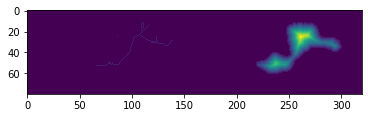

In [202]:
plt.imshow(np.concatenate([skel, distance], axis=-1))

In [213]:
xmorph = []
for i in range(len(x)):
    body = np.zeros((80, 160, 80))
    for j in range(80):
        temp = y[i, :, :, j, 0]
        skel, distance = medial_axis(temp, return_distance=True)
        body[:, :, j]  = distance/20.0
    xmorph.append(body)

xmorph = np.array(xmorph)
print(xmorph.shape)

(82, 80, 160, 80)


In [225]:
np.save('xmorph.npy', xmorph)

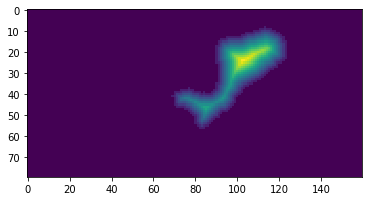

In [214]:
plt.imshow(xmorph[1, :, :, 15])

In [215]:
from skimage.data import binary_blobs

data = binary_blobs(200, blob_size_fraction=.2, volume_fraction=.35, seed=1)
print(data.shape)


(200, 200)


In [ ]:
from skimage.morphology import skeletonize_3d

skeleton_lee = skeletonize_3d(y[0, :, :, :, 0])
print(skeleton_lee.shape)

skel, distance = medial_axis(y[0, :, :, 0], return_distance=True)

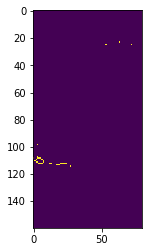

In [223]:
plt.imshow(skeleton_lee[40, :, :])